In [7]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet

### Imports

In [8]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import mne
from mne.stats.parametric import _parametric_ci
from mne import create_info
from mne.io import RawArray

from KC_algorithm.model import score_KCs
from KC_algorithm.utils import EpochData
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs

from utils.plots import plot_Kcs_in_single_chart, plot_Kcs_in_single_chart_epoch_data, plot_kcs_per_minute_and_sleep_stages
from utils.io import load_raw_edf, import_event_and_stages_SHHS, get_total_recording_time, store_kcs_data
from utils.preprocessing import remove_steady_epochs, remove_standard_deviation_outliers
from utils.postprocessing import calculate_kcs_per_minute, filter_kcs_by_sleep_stages

### Paths & Constants

In [9]:
DATASET_DIR = "/home/ec2-user/SageMaker/datasets/nsrr/shhs/"

# Get lists of all EDF and annotation files in their respective directories
edf_dir = os.path.join(DATASET_DIR, 'polysomnography/edfs/shhs1')
annot_dir = os.path.join(DATASET_DIR, 'polysomnography/annotations-events-nsrr/shhs1')
kcs_dir = os.path.join(DATASET_DIR, 'preprocessed/shhs1')

edf_files = sorted([os.path.join(edf_dir, f) for f in os.listdir(edf_dir) if f.endswith('.edf')])
annot_files = sorted([os.path.join(annot_dir, f) for f in os.listdir(annot_dir) if f.endswith('-nsrr.xml')])

# Zip the edf and annotation files together
file_paths = list(zip(edf_files, annot_files))


PROB_THRESHOLD = 0.5
SAMPLING_FREQ = 128
HIGHPASS_FILTER_CUTOFF = 0.3
STD_PREPROCESSING_CUTOFF = 3

POST_PEAK = 1.5
PRE_PEAK = 1.5

WANTED_CHANNEL = 'EEG'
WANTED_SLEEP_STAGES = [2, 3]

SLEEP_STAGE_TO_LABEL_DICT = {
    0: "Awake",
    1: "Sleep Stage 1", 
    2: "Sleep Stage 2", 
    3: "Sleep Stage 3",
    4: "Sleep Stage 4",
    5: "REM Sleep"
}

### Mne should only log errors

In [10]:
mne.set_log_level('ERROR')

### Run Inference

In [52]:
def run_inference(edf_filename, annot_filename, vis=True, store_data=False):
    # Load raw edf file data
    raw = load_raw_edf(edf_filename, SAMPLING_FREQ, HIGHPASS_FILTER_CUTOFF)

    # events and stages data from annotation xml file
    events, hypno = import_event_and_stages_SHHS(xml_file=annot_filename)

    # We multiply the channel by -1 since the algorithm was trained on negative EEG polarity
    C3 = np.asarray(
        [raw[count, :][0] for count, k in enumerate(raw.info['ch_names']) if k == WANTED_CHANNEL]).ravel() * -1
    Fs = raw.info['sfreq']


    # Run inference
    peaks, stage_peaks, d, probas = score_KCs(C3, Fs, hypno, sleep_stages=WANTED_SLEEP_STAGES)

    # Select the labels, onsets and probabillities that correspond to peaks
    labels_selected = np.where(probas > PROB_THRESHOLD, 1, 0)
    onsets_selected = peaks[probas > PROB_THRESHOLD]
    probas_selected = probas[probas > PROB_THRESHOLD]
    
    # Remove outliers
    valid_peaks, invalid_peaks, valid_indices, invalid_indices = remove_steady_epochs(onsets_selected, C3, pre_peak=1.5, post_peak=1.5, Fs=Fs, threshold=0.007)
    #valid_peaks, invalid_peaks, valid_indices, invalid_indices = remove_standard_deviation_outliers(onsets_selected, C3, PRE_PEAK, POST_PEAK, SAMPLING_FREQ, std_threshold=STD_PREPROCESSING_CUTOFF)
    
    print('{} K-complexes were detected'.format(len(list(valid_peaks))))
    # Filter the selected labels and probabilities based on valid peaks
    valid_indices = [i for i, peak in enumerate(onsets_selected) if peak in valid_peaks]
    labels_valid = labels_selected[valid_indices]
    onsets_valid = onsets_selected[valid_indices]
    probas_valid = probas_selected[valid_indices]

    # Plot the ones that were filtered out
    print('{} invalid K-complexes were detected'.format(len(list(invalid_peaks))))
    invalid_indices = [i for i, peak in enumerate(onsets_selected) if peak in invalid_peaks]
    labels_invalid = labels_selected[invalid_indices]
    onsets_invalid = onsets_selected[invalid_indices]
    probas_invalid = probas_selected[invalid_indices]
    
    
    if vis:
        ### Plot KCs by probabillity
        KC_from_probas(C3*-1, onsets_valid, probas_valid, SAMPLING_FREQ)
            
        ### Plot valid KCs
        plot_Kcs_in_single_chart(C3*-1, onsets_valid, probas_valid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
        
        ### Plot invalid KCs
        plot_Kcs_in_single_chart(C3*-1, onsets_invalid, probas_invalid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
        
        ### Plot KCs per minute
        total_duration = get_total_recording_time(annot_filename)  # in seconds
        stages = import_event_and_stages_SHHS(annot_filename)[1]

        ### Find any KCs that are in the wrong sleep stage -> Meaning the preprocessing is wrong
        onsets_valid_cleaned, onsets_valid_outside = filter_kcs_by_sleep_stages(onsets_selected, stages, WANTED_SLEEP_STAGES, SAMPLING_FREQ)

        ### Now plot the KCs in the right sleep stage
        minutes, kcs_per_minute = calculate_kcs_per_minute(onsets_valid_cleaned, SAMPLING_FREQ, total_duration)
        plot_kcs_per_minute_and_sleep_stages(minutes, kcs_per_minute, stages)


        ### And the KCs in the wrong sleep stage
        minutes_outside, kcs_per_minute_outside = calculate_kcs_per_minute(onsets_valid_outside, SAMPLING_FREQ, total_duration)
        plot_kcs_per_minute_and_sleep_stages(minutes_outside, kcs_per_minute_outside, stages)
    

    if store_data:        
        # Create epochs for valid and invalid KCs
        epochs_data_valid = EpochData(valid_peaks, C3*-1, post_peak=POST_PEAK, pre_peak=PRE_PEAK, Fs=SAMPLING_FREQ)
        epochs_data_invalid = EpochData(invalid_peaks, C3*-1, post_peak=POST_PEAK, pre_peak=PRE_PEAK, Fs=SAMPLING_FREQ)
        
        # The filename is kept consistent with existing data
        filename = os.path.basename(edf_filename).replace('.edf', '')
        
        # Sir, get ready to store the data
        store_kcs_data(kcs_dir, 
                       filename,
                       onsets_valid, 
                       probas_valid, 
                       labels_valid,
                       epochs_data_valid, 
                       onsets_invalid, 
                       probas_invalid, 
                       labels_invalid,
                       epochs_data_invalid,
                       SAMPLING_FREQ
                      )

Running inference for edf: /home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200001.edf
357 K-complexes were detected
82 invalid K-complexes were detected


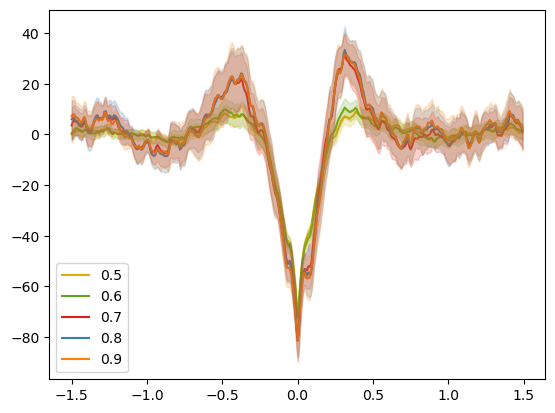

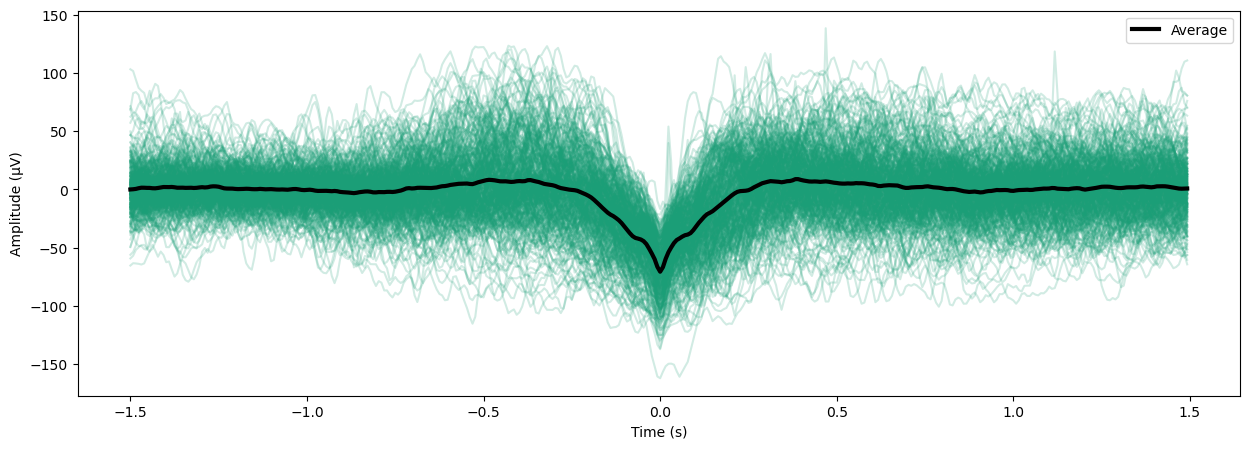

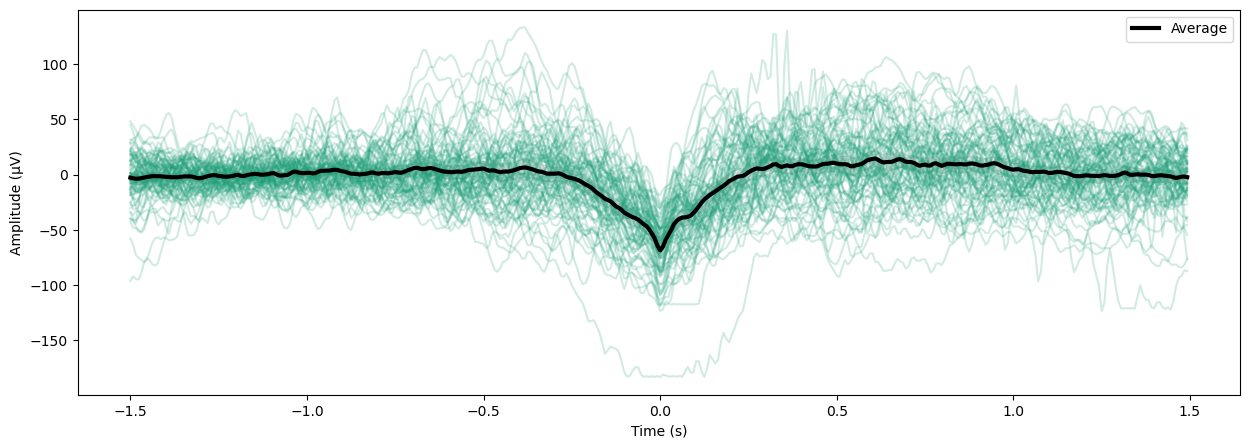

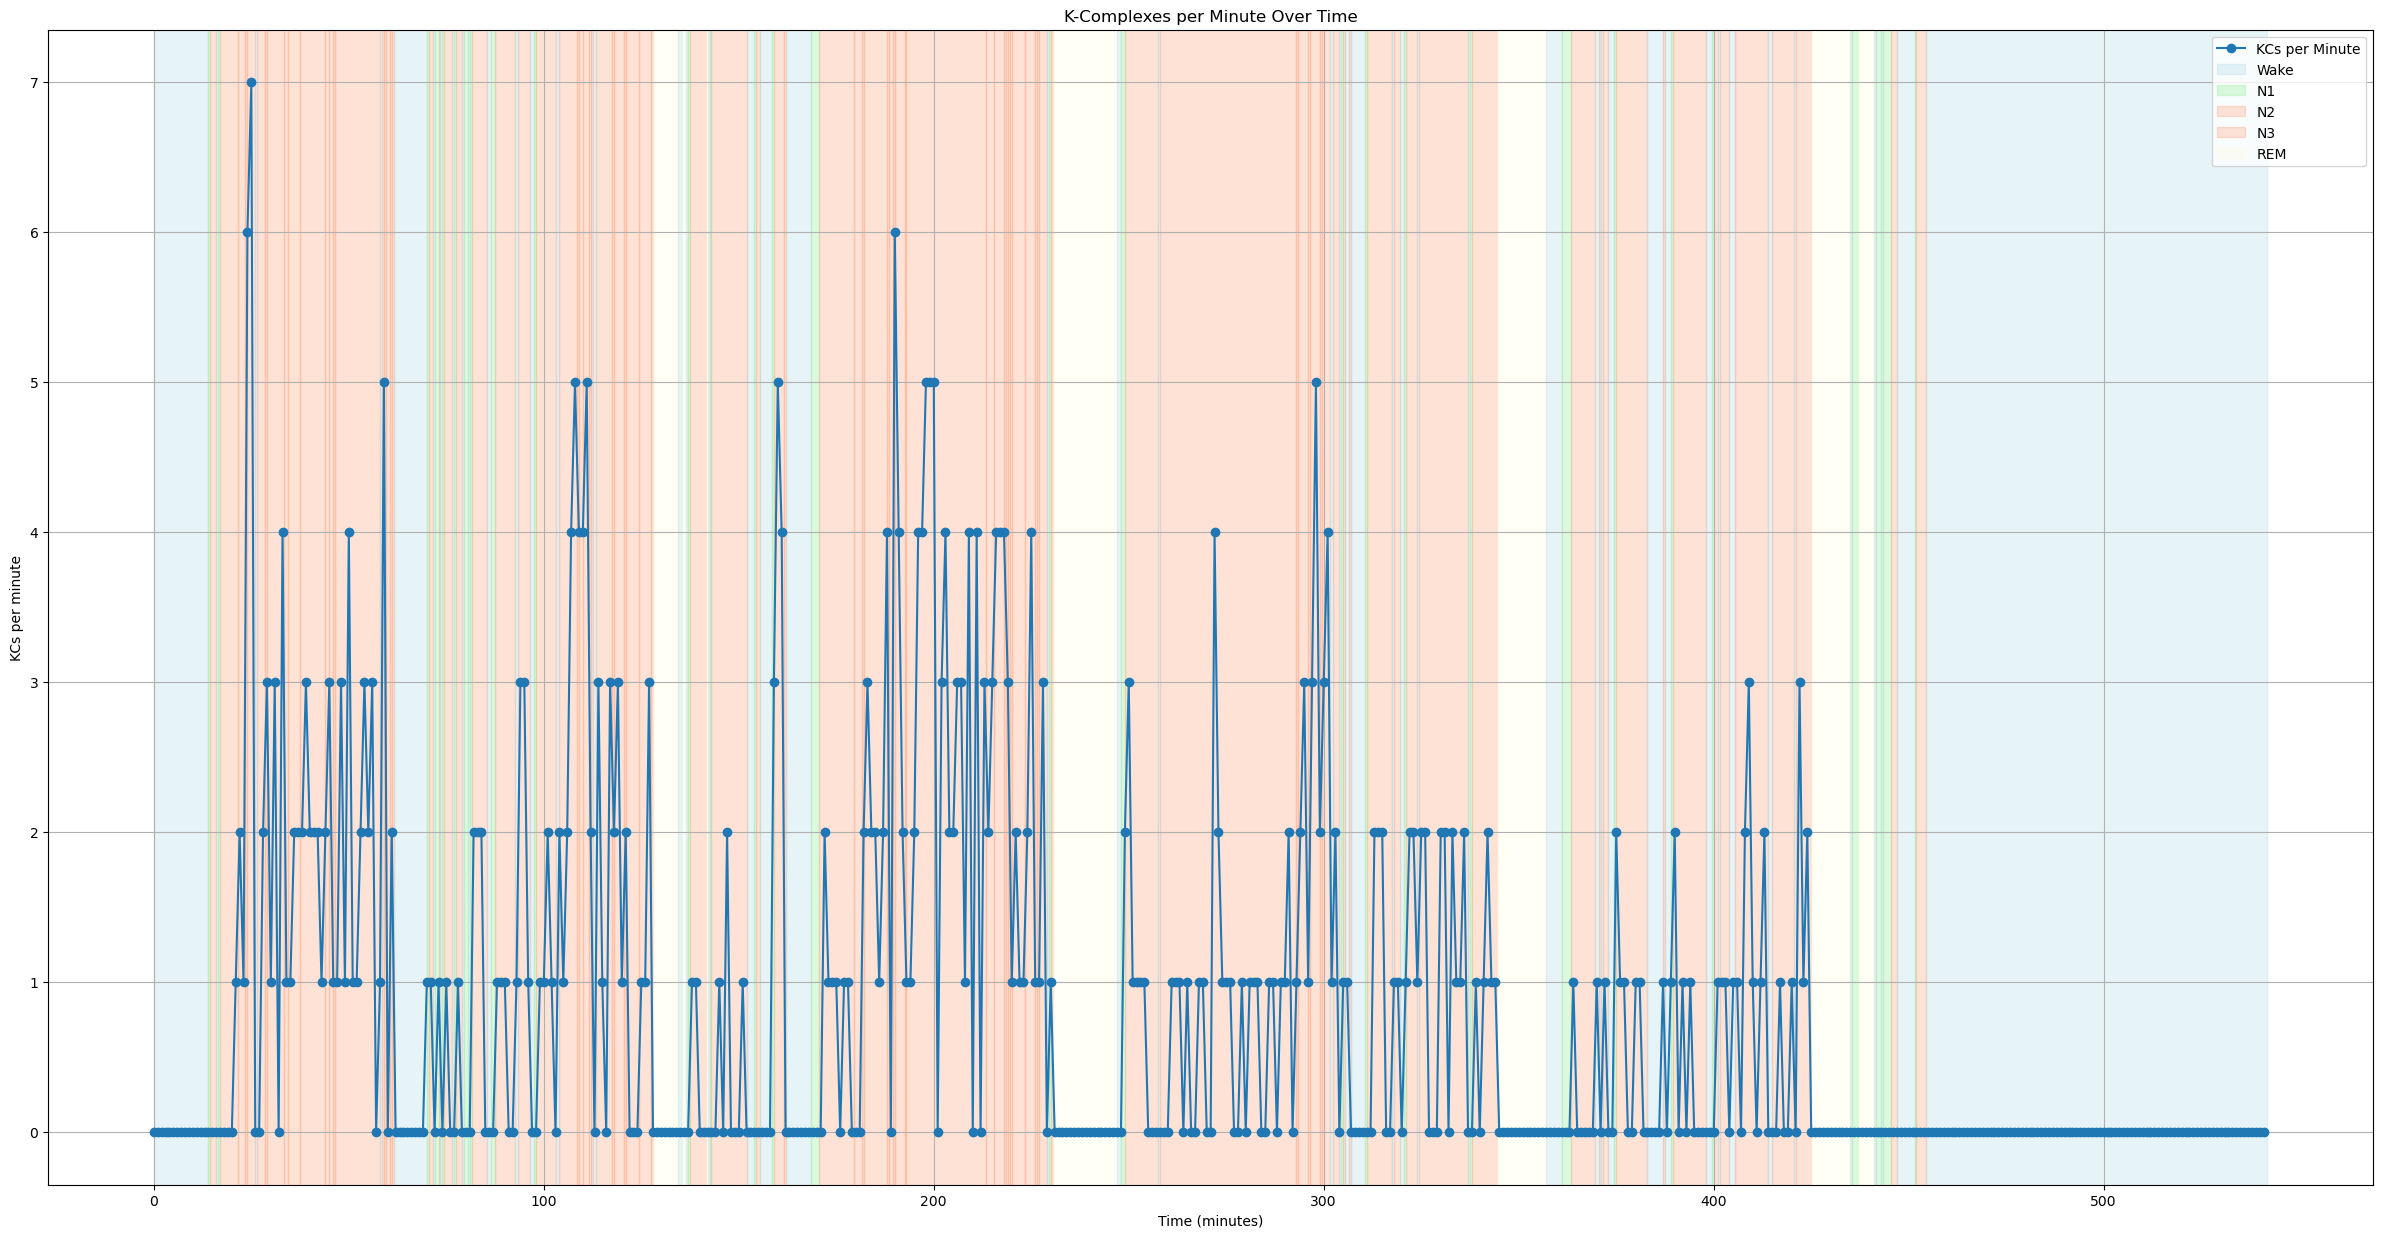

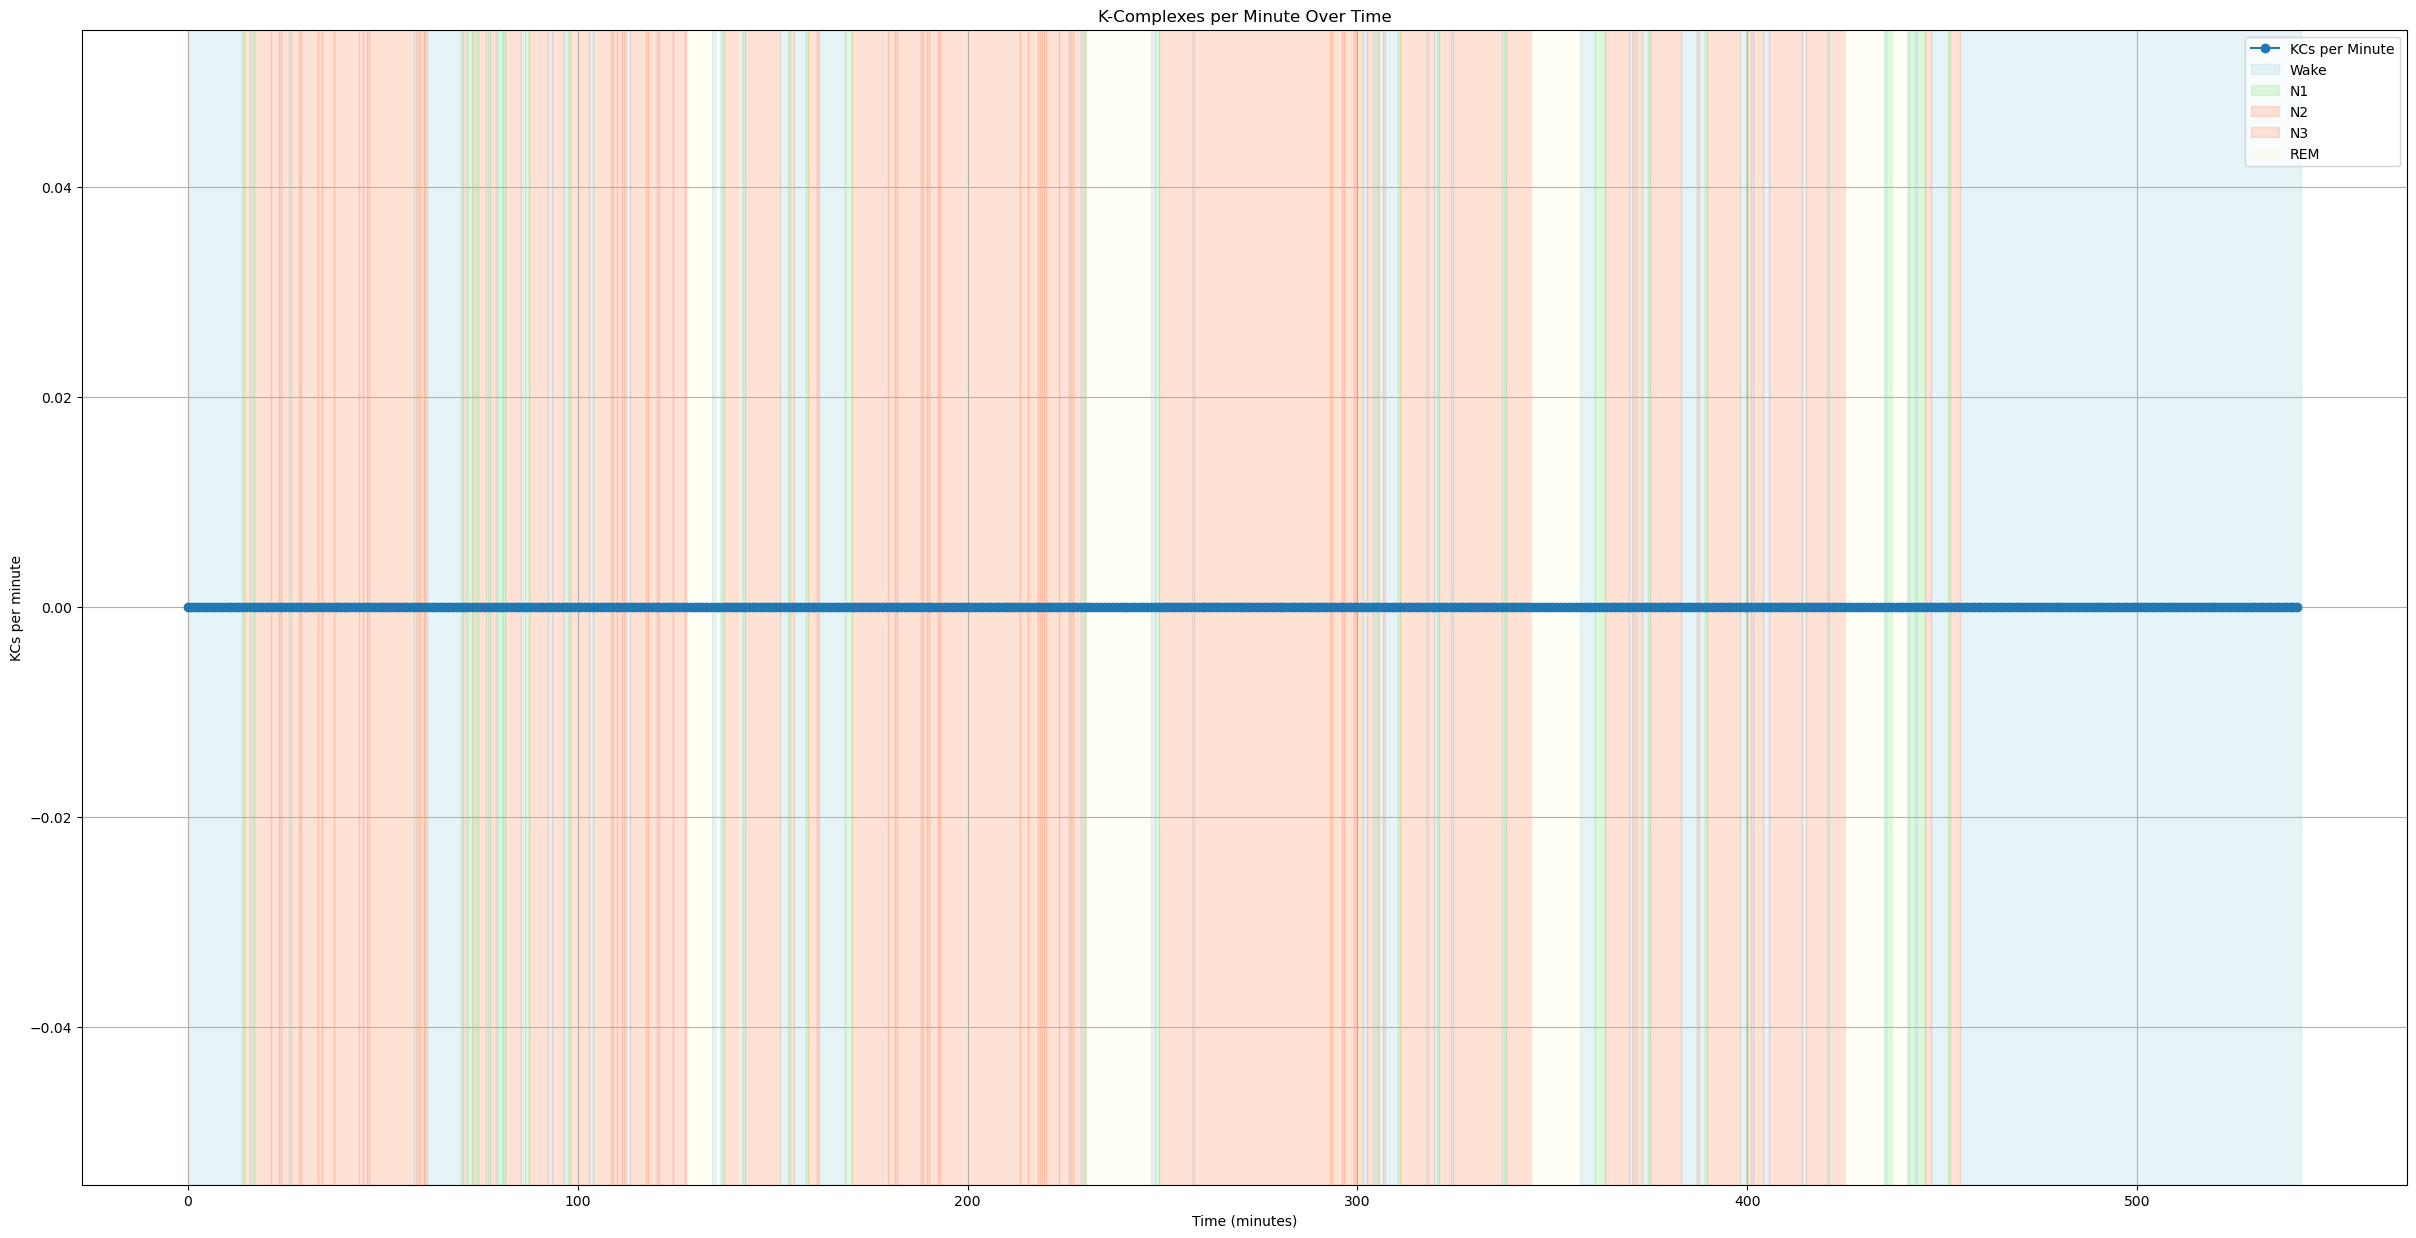

In [51]:
index = 0
edf_filename = file_paths[index][0]
annot_filename = file_paths[index][1]
run_inference(edf_filename, annot_filename, vis=True, store_data=False)

### Multiprocess Inference Execution 

In [ ]:
import concurrent.futures

def run_inference_wrapper(index, file_paths):
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    run_inference(edf_filename, annot_filename, vis=False, store_data=True)

def parallel_process(file_paths, num_processes=4):
    indices = range(len(file_paths))  # List of indices to process
    print(indices)

    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        futures = {executor.submit(run_inference_wrapper, index, file_paths): index for index in indices}
        
        for future in concurrent.futures.as_completed(futures):
            index = futures[future]
            try:
                future.result()
                print(f"Processing for index {index} completed.")
            except Exception as e:
                print(f"Error processing index {index}: {e}")

# Example usage
parallel_process(file_paths, num_processes=4)

range(0, 5793)
Running inference for edf: /home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200001.edf

Running inference for edf: /home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200002.edf
Running inference for edf: /home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200003.edfRunning inference for edf: /home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200004.edf
236 K-complexes were detected
Saved 236 valid K-complex epochs as EDF files in /home/ec2-user/SageMaker/datasets/nsrr/shhs/preprocessed/shhs1/shhs1-200004/valid_kcs/edfs
130 K-complexes were detected
Saved 230 invalid K-complex epochs as EDF files in /home/ec2-user/SageMaker/datasets/nsrr/shhs/preprocessed/shhs1/shhs1-200004/invalid_kcs/edfs
Running inference for edf: /home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200005.edf
Processing for index 3 completed.
Saved 130 valid K-complex epochs